## Use the script `network_citations.py` to build citation networks 
Give it the id of the paper you want to build a citation network for, you can keep the other parameters default. The id is the last part in the url from semantic scholar (e.g. https://www.semanticscholar.org/paper/4e9ec92a90c5d571d2f1d496f8df01f0a8f38596)


The two files generated by the script are input to read_network_csv etc.

The Semantic Scholar API prioritizes returning the most recent citations first when there are many citing papers.

In [34]:
import os
import csv
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

def read_network_csv(papers_csv, connections_csv):
    """
    Read network data from CSV files and construct the network dictionary.
    
    Parameters:
    - papers_csv: Path to the CSV file containing paper data
    - connections_csv: Path to the CSV file containing connection data
    
    Returns:
    - Dictionary with the network structure
    """
    network_data = {
        "papers": {},
        "connections": []
    }
    
    # Read papers data
    with open(papers_csv, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            paper_id = row['paper_id']
            network_data["papers"][paper_id] = {
                "title": row['title'],
                "authors": [author.strip() for author in row['authors'].split(';')] if row['authors'] else [],
                "year": int(row['year']) if row['year'] and row['year'].isdigit() else None,
                "venue": row['venue'],
                "url": row['url']
            }
    
    # Read connections data
    with open(connections_csv, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            network_data["connections"].append({
                "source": row['source'],
                "target": row['target']
            })
    
    return network_data

def extract_author_collaboration_network(citation_network):
    """
    Extract author collaboration network from citation network.
    
    Returns a dictionary mapping author pairs to collaboration count.
    """
    collaborations = defaultdict(int)
    author_papers = defaultdict(list)
    
    # Check if we have papers to process
    if not citation_network["papers"]:
        print("WARNING: No papers in citation network, cannot extract author collaborations.")
        return {
            "collaborations": {},
            "author_papers": {}
        }
    
    # Collect all papers for each author
    for paper_id, paper_info in citation_network["papers"].items():
        authors = paper_info["authors"]
        
        if not authors:
            continue
            
        # Record each author's papers
        for author in authors:
            if author:  # Skip empty authors
                author_papers[author].append(paper_id)
        
        # Record collaborations within papers
        for i in range(len(authors)):
            for j in range(i+1, len(authors)):
                # Skip if either author is empty
                if not authors[i] or not authors[j]:
                    continue
                    
                # Use tuple to ensure order doesn't matter
                author_pair = tuple(sorted([authors[i], authors[j]]))
                collaborations[author_pair] += 1
    
    return {
        "collaborations": dict(collaborations),
        "author_papers": dict(author_papers)
    }


def visualize_author_network(author_data, top_authors=20, min_collaborations=2, output_file="author_network.png"):
    """
    Visualize the author collaboration network using NetworkX.
    
    Parameters:
    - author_data: Dictionary with collaborations and author_papers
    - top_authors: Maximum number of authors to display
    - min_collaborations: Minimum number of collaborations to show a connection
    - output_file: Path to save the visualization
    """
    if not author_data["collaborations"]:
        print("WARNING: No collaborations to visualize author network.")
        return None
    
    G = nx.Graph()
    
    # Filter collaborations by minimum weight
    filtered_collaborations = {pair: weight for pair, weight in author_data["collaborations"].items() 
                              if weight >= min_collaborations}
    
    if not filtered_collaborations:
        print(f"WARNING: No collaborations with at least {min_collaborations} papers together.")
        # Fall back to using all collaborations
        filtered_collaborations = author_data["collaborations"]
    
    # Identify top authors by number of papers
    author_paper_counts = {author: len(papers) for author, papers in author_data["author_papers"].items()}
    top_author_list = sorted(author_paper_counts.items(), key=lambda x: x[1], reverse=True)[:top_authors]
    top_author_set = set(author for author, _ in top_author_list)
    
    # Add nodes for top authors
    for author, paper_count in top_author_list:
        G.add_node(author, papers=paper_count)
    
    # Add edges for collaborations between top authors
    for (author1, author2), weight in filtered_collaborations.items():
        if author1 in top_author_set and author2 in top_author_set:
            G.add_edge(author1, author2, weight=weight)
    
    if not G.nodes():
        print("WARNING: No nodes to visualize in author network.")
        return None
    
    # Remove isolated nodes
    isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
    G.remove_nodes_from(isolated_nodes)
    print(f"Removed {len(isolated_nodes)} isolated authors from visualization")
    
    plt.figure(figsize=(14, 14))
    
    # Position nodes using force-directed layout with stronger repulsion for better spacing
    #pos = nx.spring_layout(G, k=0.5, iterations=100)
    pos = nx.kamada_kawai_layout(G)  # Often gives more organic layouts
    
    # Node sizes based on number of papers
    node_sizes = [author_paper_counts[author] * 30 for author in G.nodes()]
    
    # Edge widths based on collaboration count
    edge_weights = [G[u][v]['weight'] * 0.8 for u, v in G.edges()]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.7, 
                          node_color='lightblue', edgecolors='black')
    
    # Draw edges with width proportional to collaboration strength
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color='gray')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
    
    plt.title(f"Author Collaboration Network (Top {len(G.nodes())} authors)")
    plt.axis('off')
    plt.tight_layout()
    
    plt.show()
    
    return G

 

In [47]:
def visualize_citation_network(network_data, max_nodes=50, min_citations=1, output_file="citation_network.png"):
    """
    Visualize the citation network using NetworkX with improved visibility.
    
    Parameters:
    - network_data: Dictionary with papers and connections
    - max_nodes: Maximum number of papers to include in visualization
    - min_citations: Minimum number of citations for a paper to be included
    - output_file: Path to save the visualization
    """
    import networkx as nx
    import matplotlib.pyplot as plt
    import os
    
    if not network_data["papers"] or not network_data["connections"]:
        print("WARNING: Not enough data to visualize citation network.")
        return None
    
    # Count citations for each paper
    citation_counts = {}
    for connection in network_data["connections"]:
        target = connection["target"]
        citation_counts[target] = citation_counts.get(target, 0) + 1
    
    # Filter papers by citation count
    significant_papers = {paper_id: paper_info for paper_id, paper_info in network_data["papers"].items()
                         if citation_counts.get(paper_id, 0) >= min_citations}
    
    # Take the top papers by citation count
    top_papers = sorted(
        [(paper_id, citation_counts.get(paper_id, 0)) for paper_id in significant_papers],
        key=lambda x: x[1], reverse=True
    )[:max_nodes]
    
    top_paper_ids = set(paper_id for paper_id, _ in top_papers)
    
    G = nx.DiGraph()
    
    # Add nodes (papers)
    for paper_id in top_paper_ids:
        paper_info = network_data["papers"][paper_id]
        G.add_node(
            paper_id, 
            title=paper_info["title"], 
            year=paper_info["year"],
            citations=citation_counts.get(paper_id, 0)
        )
    
    # Add edges (citations) between the top papers
    for connection in network_data["connections"]:
        source = connection["source"]
        target = connection["target"]
        if source in top_paper_ids and target in top_paper_ids:
            G.add_edge(source, target)
    
    if not G.nodes():
        print("WARNING: No nodes to visualize in citation network.")
        return None
    
    # Always remove isolated nodes as requested
    isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
    G.remove_nodes_from(isolated_nodes)
    if isolated_nodes:
        print(f"Removed {len(isolated_nodes)} isolated papers from visualization")
    
    plt.figure(figsize=(10, 10))
    
    # Use a more organic layout for better spacing
    pos = nx.kamada_kawai_layout(G)
    
    # Calculate degree centrality for node sizing
    degree_dict = dict(G.degree())
    
    # Node sizes based on both citation count AND connectivity (degree)
    node_sizes = []
    for paper_id in G.nodes():
        # Base size from citations
        base_size = citation_counts.get(paper_id, 1) * 15 + 50
        # Add bonus size for well-connected nodes
        connectivity_bonus = degree_dict[paper_id] * 10  # Emphasize nodes with many connections
        node_sizes.append(base_size + connectivity_bonus)
    
    # Color nodes by year if available
    node_colors = []
    years = [G.nodes[paper_id].get('year', 0) for paper_id in G.nodes()]
    if years and any(years):
        min_year = min(y for y in years if y > 0) if any(y > 0 for y in years) else 2000
        max_year = max(years) if years else min_year + 10
        
        for paper_id in G.nodes():
            year = G.nodes[paper_id].get('year', 0)
            if year > 0:
                # Normalize year to 0-1 range for color mapping
                normalized_year = (year - min_year) / max(1, max_year - min_year)
                node_colors.append(normalized_year)
            else:
                node_colors.append(0)
    else:
        node_colors = 'lightblue'
    
    # Draw nodes with varying sizes based on citation count AND connectivity
    nodes = nx.draw_networkx_nodes(
        G, pos, 
        node_size=node_sizes, 
        node_color=node_colors,
        cmap=plt.cm.viridis if isinstance(node_colors, list) else None,
        alpha=0.8,
        edgecolors='black'
    )
    
    # Draw edges with arrows
    nx.draw_networkx_edges(
        G, pos, 
        alpha=0.5, 
        arrows=True,
        arrowsize=15,
        width=0.8,
        edge_color='gray'
    )
    
    # Create shorter labels with paper titles
    labels = {}
    for paper_id in G.nodes():
        title = G.nodes[paper_id].get('title', '')
        # Create a short label (first 15 chars)
        if title:
            short_title = title[:15] + "..." if len(title) > 15 else title
            labels[paper_id] = short_title
        else:
            labels[paper_id] = str(paper_id)[:8]
    
    # Draw labels with better visibility
    nx.draw_networkx_labels(
        G, pos, 
        labels=labels, 
        font_size=8,
        font_weight='bold',
        font_color='black',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
    )
    
    # Add a title with network stats
    plt.title(f"Citation Network ({len(G.nodes())} papers, {len(G.edges())} citations)")
    plt.axis('off')
    plt.tight_layout()
    

    plt.show()
    
    return G

Reading network data from CSV files...
Extracting author collaboration network...
Creating citation network visualization...


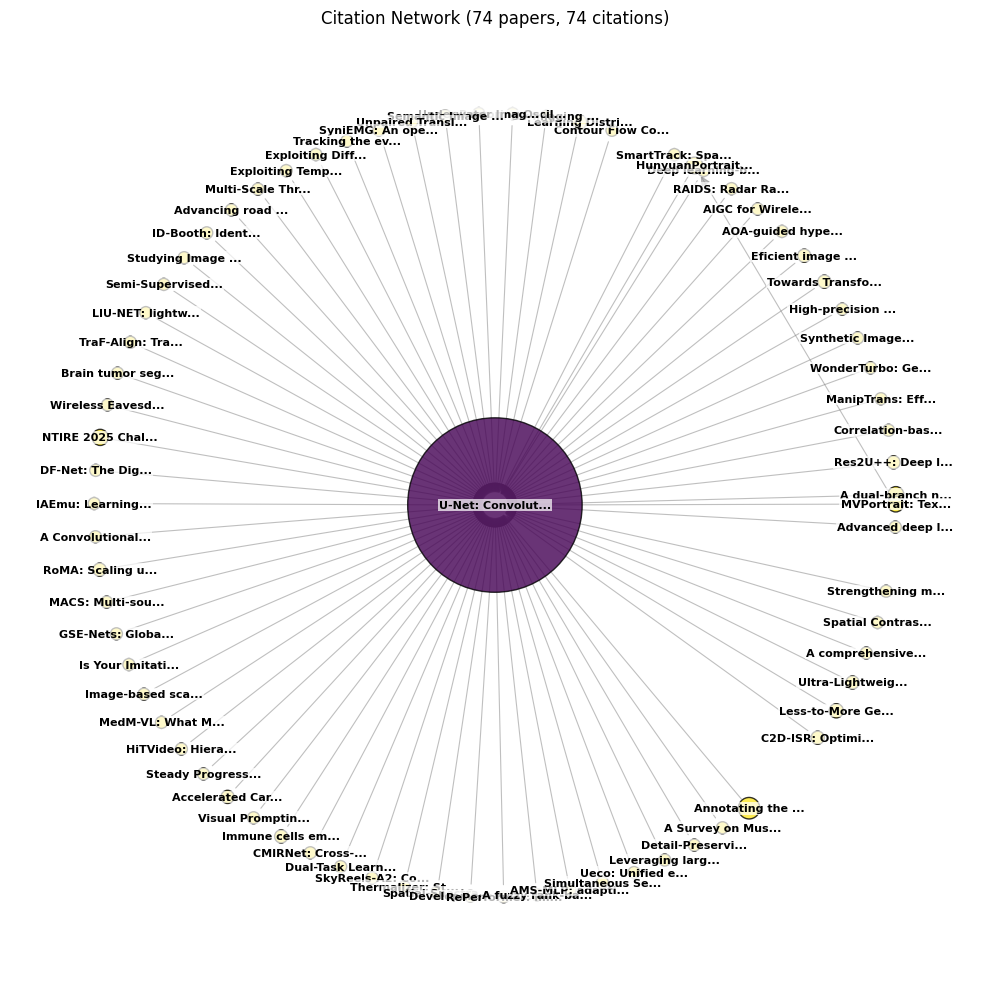

Creating author collaboration network visualization...
Removed 39 isolated authors from visualization


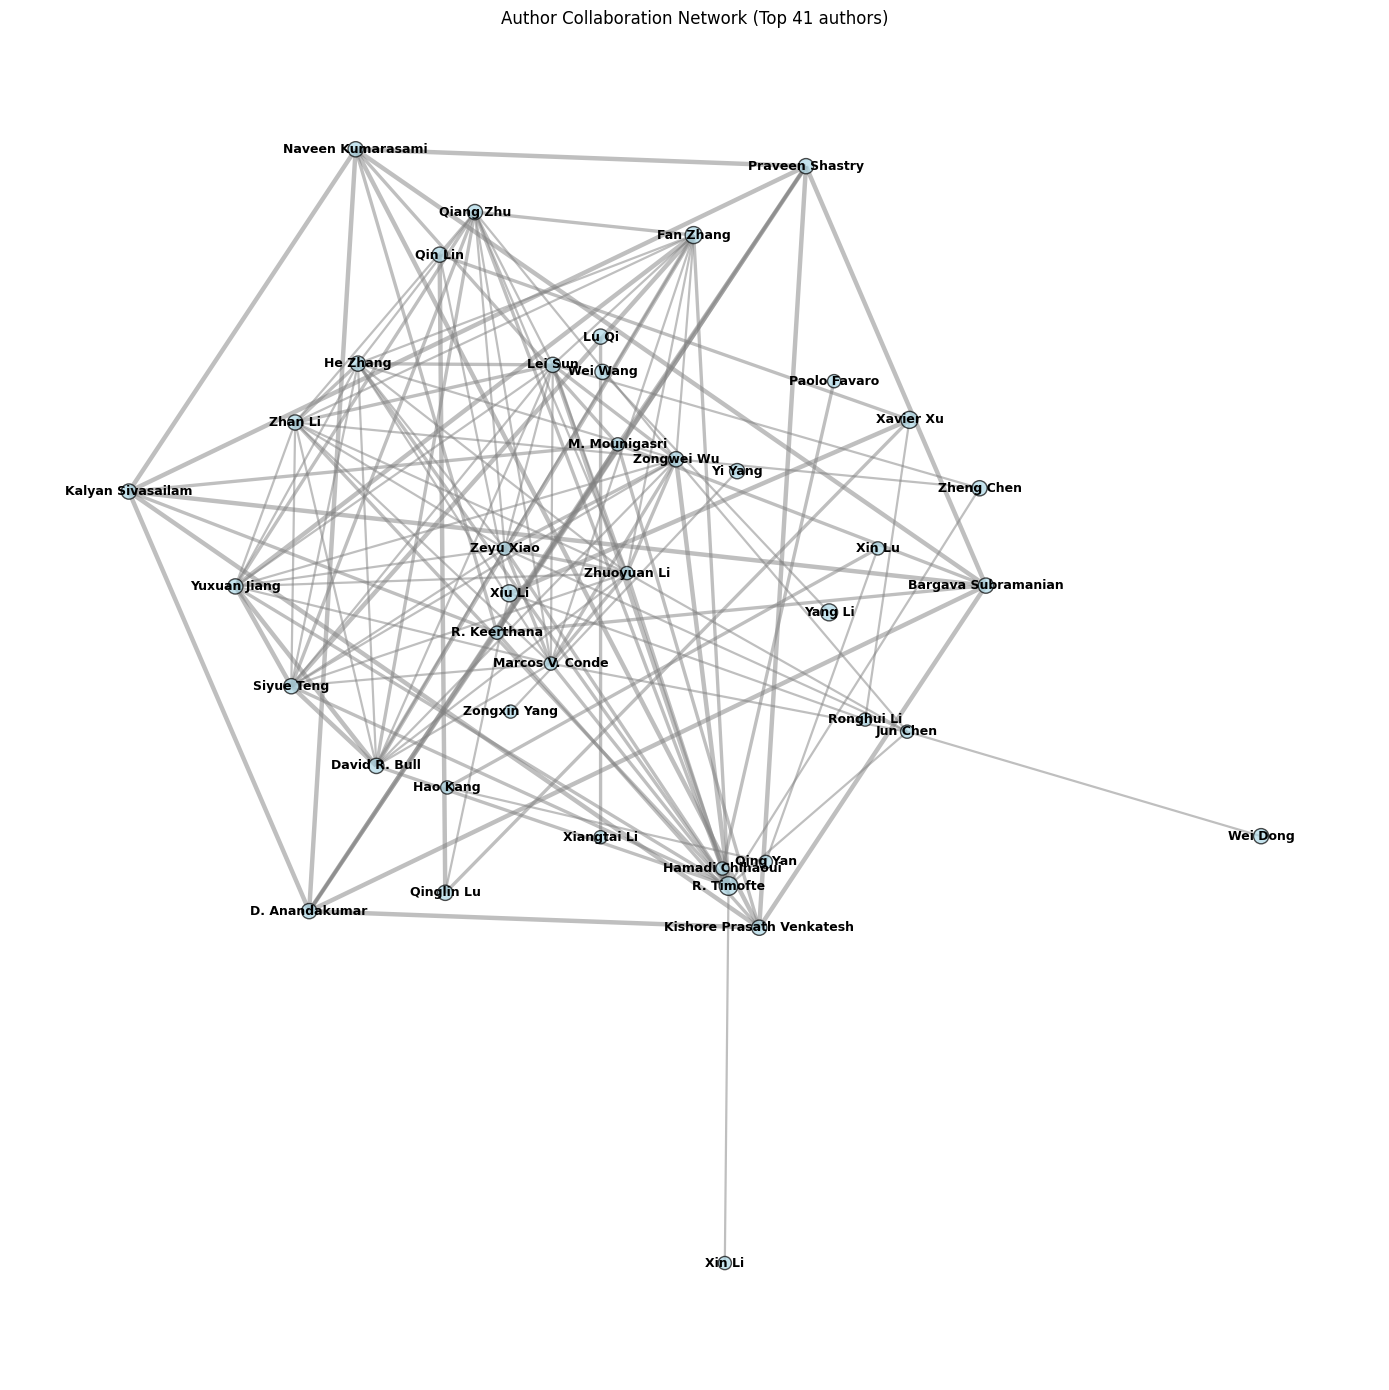

Done!


In [49]:

# Get input file paths
papers_csv = "/home/syrine/Desktop/MA4/DataViz/citations/semantic_scholar_6364fdaa0a0eccd823a779fcdd489173f938e91a_citations_papers.csv"
connections_csv = "/home/syrine/Desktop/MA4/DataViz/citations/semantic_scholar_6364fdaa0a0eccd823a779fcdd489173f938e91a_citations_connections.csv"
#connections_csv = "semantic_scholar_4e9ec92a90c5d571d2f1d496f8df01f0a8f38596_citations_connections.csv"
#papers_csv = "semantic_scholar_4e9ec92a90c5d571d2f1d496f8df01f0a8f38596_citations_papers.csv"


# Read data from CSV files
print("Reading network data from CSV files...")
network_data = read_network_csv(papers_csv, connections_csv)

# Extract author collaboration network
print("Extracting author collaboration network...")
author_network = extract_author_collaboration_network(network_data)



# Visualize citation network
print("Creating citation network visualization...")
visualize_citation_network(network_data,max_nodes=100, min_citations=1)

# Visualize author network
print("Creating author collaboration network visualization...")
visualize_author_network(author_network, top_authors=80, min_collaborations=2)

print("Done!")

